#**Neural Style Transfer**
Apply the artistic style of one image (eg. a famous painting)to the content of another image using neural style transfer

In [ ]:
import os
import tensorflow as tf
print(tf.__version__)
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import time
import functools

2.15.0


In [ ]:
def load_image(image):
  max_dim = 512
  image = tf.io.read_file(image)
  image = tf.image.decode_jpeg(image, channels=3)
  image= tf.image.convert_image_dtype(image, tf.float32)
  shape = tf.cast(tf.shape(image)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim
  new_shape = tf.cast(shape * scale, tf.int32)
  image = tf.image.resize(image, new_shape)
  image = image[tf.newaxis, :]
  return image

In [ ]:
#download the images
content_path = "/content/contain.png"
style_path = "/content/style.png"

In [ ]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)
  plt.imshow(image)
  if title:
    plt.title(title)

In [ ]:
content_image = load_image(content_path)
style_image = load_image(style_path)
print(content_image.shape)
print(style_image.shape)

(1, 384, 512, 3)
(1, 384, 512, 3)


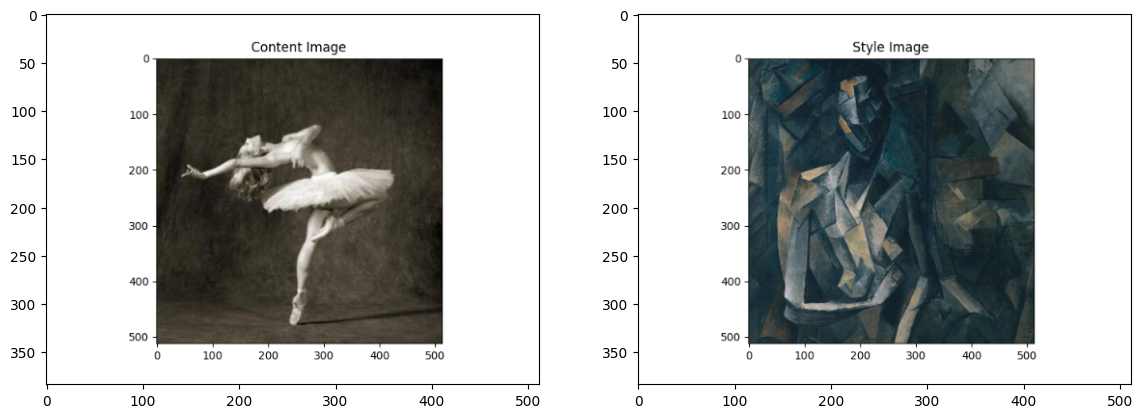

In [ ]:
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
imshow(content_image)
plt.subplot(1, 2, 2)
imshow(style_image)

In [ ]:
x= tf.keras.applications.vgg19.preprocess_input(content_image*255)
x=tf.image.resize(x,(224,224))
x.shape

TensorShape([1, 224, 224, 3])

In [ ]:
vgg = tf.keras.applications.vgg19.VGG19(weights='imagenet',include_top=False)
vgg.summary()

80134624/80134624 [==============================] - 3s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

In [ ]:
for layer in vgg.layers:
  print(layer.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [ ]:
content_layers = ['block5_conv2']

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [ ]:
def vgg_layers(layer_names):
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  outputs = [vgg.get_layer(name).output for name in layer_names]
  model = tf.keras.Model([vgg.input], outputs)
  return model

In [ ]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

In [ ]:
for i in style_outputs:
  print(i.shape)

(1, 384, 512, 64)
(1, 192, 256, 128)
(1, 96, 128, 256)
(1, 48, 64, 512)
(1, 24, 32, 512)


In [ ]:
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("shape",output.numpy().shape)
  print("min",output.numpy().min())
  print("max",output.numpy().max())
  print("mean",output.numpy().mean())
  print()

block1_conv1
shape (1, 384, 512, 64)
min 0.0
max 889.5456
mean 26.442366

block2_conv1
shape (1, 192, 256, 128)
min 0.0
max 5692.822
mean 156.20537

block3_conv1
shape (1, 96, 128, 256)
min 0.0
max 11349.785
mean 144.04054

block4_conv1
shape (1, 48, 64, 512)
min 0.0
max 21263.498
mean 538.06757

block5_conv1
shape (1, 24, 32, 512)
min 0.0
max 2951.8267
mean 36.418095



In [ ]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum("fijc,fijd->fcd", input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [ ]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    inputs = inputs*255.0
    preprocesse_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocesse_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])
    style_outputs = [gram_matrix(style_output)for style_output in style_outputs]
    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}
    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}
    return {'content': content_dict, 'style': style_dict}


In [ ]:
extractor = StyleContentModel(style_layers, content_layers)
result = extractor(tf.constant(content_image))

print("styles:")
for name, output in sorted (result['style'].items()):
  print(" ", name)
  print("shape:",output.numpy().shape)
  print("min:",output.numpy().min())
  print("max:",output.numpy().max())
  print("mean:",output.numpy().mean())
  print()

styles:
  block1_conv1
shape: (1, 64, 64)
min: 0.0040784325
max: 119640.69
mean: 547.8634

  block2_conv1
shape: (1, 128, 128)
min: 0.0
max: 187846.77
mean: 17062.168

  block3_conv1
shape: (1, 256, 256)
min: 0.0
max: 443869.38
mean: 16785.697

  block4_conv1
shape: (1, 512, 512)
min: 0.0
max: 4236868.0
mean: 176535.47

  block5_conv1
shape: (1, 512, 512)
min: 0.0
max: 119656.25
mean: 928.9842



In [ ]:
for name, output in sorted (result['content'].items()):
  print(" ", name)
  print("shape:",output.numpy().shape)
  print("min:",output.numpy().min())
  print("max:",output.numpy().max())
  print("mean:",output.numpy().mean())
  print()

  block5_conv2
shape: (1, 24, 32, 512)
min: 0.0
max: 971.7523
mean: 10.417486



In [ ]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

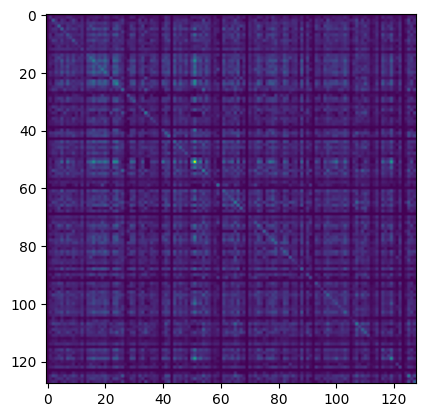

In [ ]:
plt.imshow(style_targets['block2_conv1'].numpy()[0])

In [ ]:
image = tf.Variable(content_image)

In [ ]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [ ]:
optim = tf.optimizers.Adam(learning_rate=0.01, beta_1=0.99, epsilon=1e-1)

In [ ]:
style_weight=1e-2
content_weight=1e4

In [ ]:
def style_content_loss(outputs):
  style_outputs = outputs['style']
  content_outputs = outputs['content']
  style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                         for name in style_outputs.keys()])
  style_loss *= style_weight/num_style_layers
  content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                           for name in content_outputs.keys()])
  content_loss *= content_weight/num_content_layers
  loss = style_loss + content_loss
  return loss

In [ ]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
  grad = tape.gradient(loss, image)
  optim.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

In [ ]:
for i in range(4):
  train_step(image)

In [ ]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return Image.fromarray(tensor)

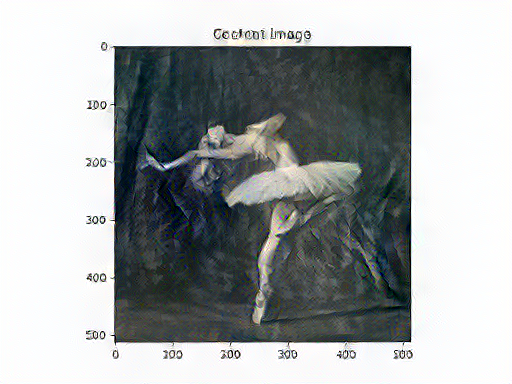

In [ ]:
import IPython.display as display
from PIL import Image
epochs = 10
steps_per_epoch = 100
step = 0
for epoch in range(epochs):
  for step in range(steps_per_epoch):
    step += 1
    train_step(image)
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))

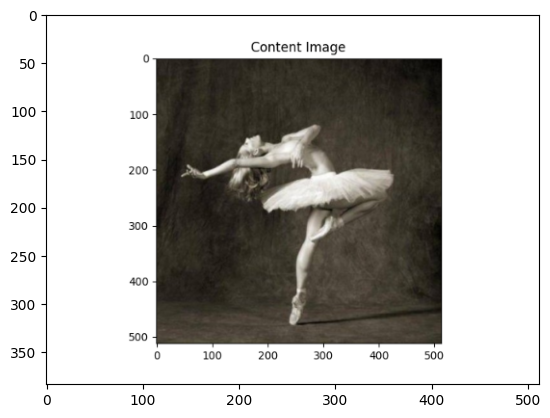

In [ ]:
imshow(content_image)